# Sistem Rekomendasi Pekerjaan - Robert Varian


Deskripsi Proyek
Dalam era digital saat ini, pencari kerja dihadapkan pada berbagai pilihan pekerjaan yang tersedia secara online. Namun, banyaknya informasi ini dapat membuat pencari kerja kesulitan dalam menemukan pekerjaan yang sesuai dengan keterampilan dan minat mereka. Sistem rekomendasi pekerjaan bertujuan untuk membantu pencari kerja dengan menyarankan posisi yang relevan berdasarkan profil dan preferensi mereka.

Dataset yang digunakan diambil dari Kaggle:
[Kaggle](https://www.kaggle.com/datasets/tondji/jobs-data-for-recommender-systems)

## Variabel Utama:
* job_title: Judul pekerjaan
* company_name: Nama perusahaan yang menawarkan pekerjaan
* job_description: Deskripsi lengkap pekerjaan
* tfidf_matrix: Matriks TF-IDF hasil transformasi fitur teks gabungan
* cosine_sim: Matriks kesamaan cosine similarity antar pekerjaan
* idx: Indeks baris pekerjaan dalam dataframe sesuai judul pekerjaan input
* sim_scores: Daftar skor kemiripan pekerjaan dengan input pekerjaan
* job_indices: Indeks pekerjaan hasil rekomendasi berdasarkan kemiripan

# Load Library

In [129]:
# # 1. Uninstall numpy dan scikit-surprise dulu
# !pip uninstall -y numpy scikit-surprise

# # 2. Install versi numpy yang stabil dan kompatibel
# !pip install numpy==1.23.5

# # 3. Install scikit-surprise
# !pip install scikit-surprise --no-binary scikit-surprise

In [130]:
!pip install rapidfuzz

In [131]:
!pip install numpy==1.23.5

In [132]:
!pip install scikit-surprise

In [151]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise.accuracy import rmse, mae
from wordcloud import WordCloud
import nltk
from rapidfuzz import process
from nltk.corpus import stopwords
from sklearn.feature_extraction import text

In [134]:
# Download stopwords bahasa Prancis (jalankan sekali saja)
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Data Preparation

## Data Loading

In [135]:
# Memasukkan json kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"grandhavoc","key":"53aad8c892f982db09c5547e125582c7"}'}

In [136]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [137]:
!pip install kaggle

In [138]:
!kaggle datasets download -d tondji/jobs-data-for-recommender-systems

Dataset URL: https://www.kaggle.com/datasets/tondji/jobs-data-for-recommender-systems
License(s): CC0-1.0
jobs-data-for-recommender-systems.zip: Skipping, found more recently modified local copy (use --force to force download)


In [139]:
# Unzip file yang telah didownload
!unzip jobs-data-for-recommender-systems.zip

Archive:  jobs-data-for-recommender-systems.zip
replace ALL_Offers.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: ALL_Offers.csv          
  inflating: jobs.json               
  inflating: offers.csv              
  inflating: offers.json             
  inflating: organizations.csv       
  inflating: users.csv               


In [140]:
jobs = pd.read_csv('ALL_Offers.csv')
jobs = pd.DataFrame(jobs)

In [141]:
display(jobs.head(), jobs.shape)

,posted_by_id,status,city,job_title,organization_id,contracts,description,skills
0,1,published,Bondues,Stagiaire (H/F) Assistant Marketing Nutritionnel,1,Stage6mois,Entreprise Le Groupe LACTALIS (près de ...,{'skills': {'communication': 1}}
1,2,published,Rhône,Expert process traitement thermique h/f,2,CDI,Entreprise Filiale européenne du groupe...,"{'skills': {'communication': 1, 'consulting': ..."
2,3,published,Paris,Charge d'operation grands comptes h/f,3,CDI,"Entreprise Notre client, première socié...","{'skills': {'collaboration': 1, 'reporting': 1..."
3,4,published,Rueil-Malmaison,Ingénieur Génie Civil stage F/H,4,Stage6mois,Entreprise Acteur mondial et leader eur...,"{'skills': {'collaboration': 1, 'ensemble': 1,..."
4,5,published,Levallois-Perret,Chargé pricing H/F,5,CDI,"Entreprise ALLIANCE AUTOMOTIVE France, ...","{'skills': {'collaboration': 1, 'leadership': 1}}"


(8867, 8)

## Data Understanding

### Mengecek data kosong dan duplikat


In [142]:
print("Jumlah data kosong per kolom:\n", jobs.isnull().sum())
print("Jumlah data duplikat:", jobs.duplicated().sum())

Jumlah data kosong per kolom:
 posted_by_id       0
status             0
city               0
job_title          0
organization_id    0
contracts          0
description        0
skills             0
dtype: int64
Jumlah data duplikat: 141


### Informasi kolom dan contoh isi

In [143]:
print("Daftar kolom:", jobs.columns)
print("Contoh deskripsi pekerjaan:\n", jobs['description'].iloc[0])

Daftar kolom: Index(['posted_by_id', 'status', 'city', 'job_title', 'organization_id',
       'contracts', 'description', 'skills'],
      dtype='object')
Contoh deskripsi pekerjaan:
     Entreprise    Le Groupe LACTALIS (près de 75 000 collaborateurs, plus de 210 sites de production, 16,5 Mds d'euros de CA), 1er Groupe Laitier Mondial, poursuit sa croissance parmi les leaders de l'industrie alimentaire tout en affirmant sa culture familiale.Nous vous invitons à participer à notre développement et à celui de nos marques prestigieuses : PRESIDENT, GALBANI, LACTEL, LA LAITIERE, SOCIETE, BRIDEL, PARMALAT...                                                                              Voir toutes les offres de l'entreprise                                                                                  Poste                                                    Nous recherchons un(e) :Stagiaire (H/F) Assistant(e) Marketing Nutritionnel (6 mois) Proximité Lille (59) Le stage Au sein de la Direc

## Exploratory Data Analysis (EDA)

### Menampilkan distribusi pekerjaan berdasarkan kategori (misal kolom 'category' ada)

In [144]:
if 'category' in jobs.columns:
    plt.figure(figsize=(12,6))
    sns.countplot(data=jobs, y='category', order=jobs['category'].value_counts().index)
    plt.title('Distribusi Pekerjaan per Kategori')
    plt.show()

### Visualisasi top 10 judul pekerjaan

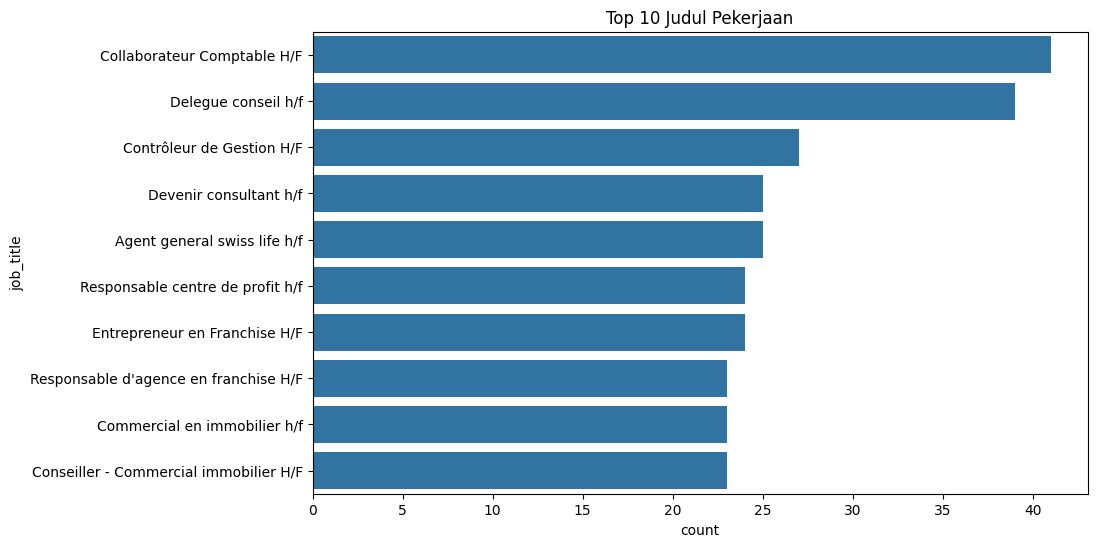

In [145]:
plt.figure(figsize=(10,6))
sns.countplot(y='job_title', data=jobs, order=jobs['job_title'].value_counts().index[:10])
plt.title('Top 10 Judul Pekerjaan')
plt.show()
plt.show()

### WordCloud untuk deskripsi pekerjaan

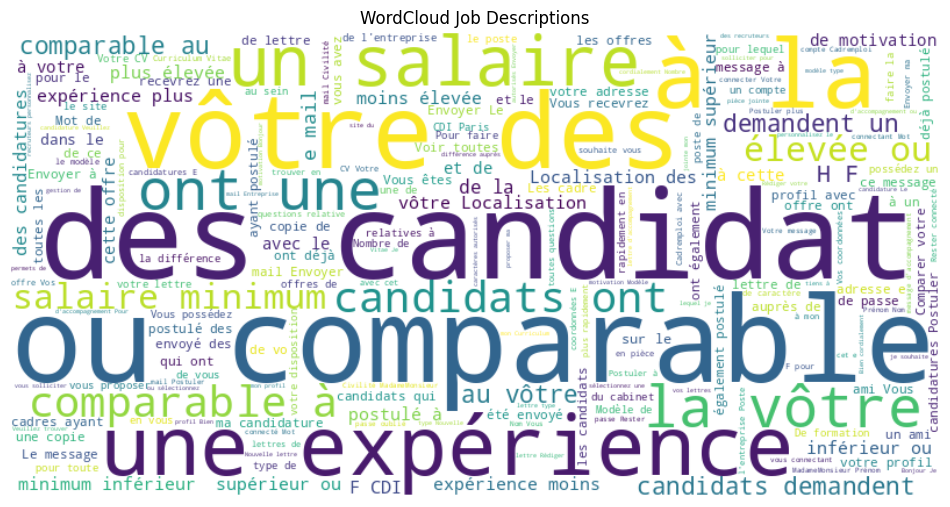

In [146]:
text = ' '.join(jobs['description'].dropna())
wc = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(12,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud Job Descriptions')
plt.show()

### Visualisasi Distribusi Jenis Pekerjaan (job_title) Teratas

<ipython-input-147-114176c9ddf9>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_job_titles.values, y=top_job_titles.index, palette='magma')


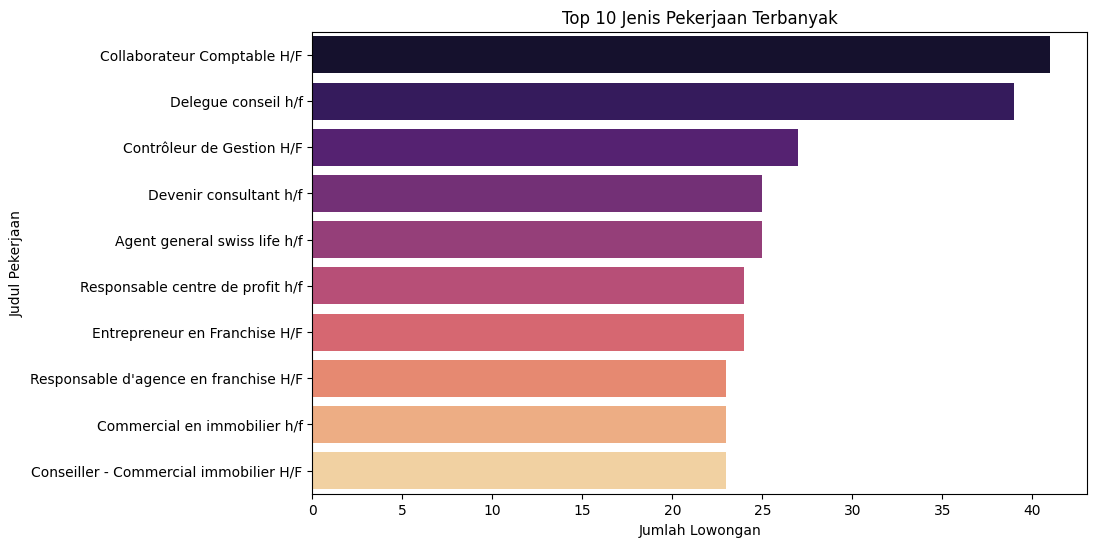

In [147]:
top_job_titles = jobs['job_title'].value_counts().head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=top_job_titles.values, y=top_job_titles.index, palette='magma')
plt.title('Top 10 Jenis Pekerjaan Terbanyak')
plt.xlabel('Jumlah Lowongan')
plt.ylabel('Judul Pekerjaan')
plt.show()

### Visualisasi Panjang Deskripsi Pekerjaan

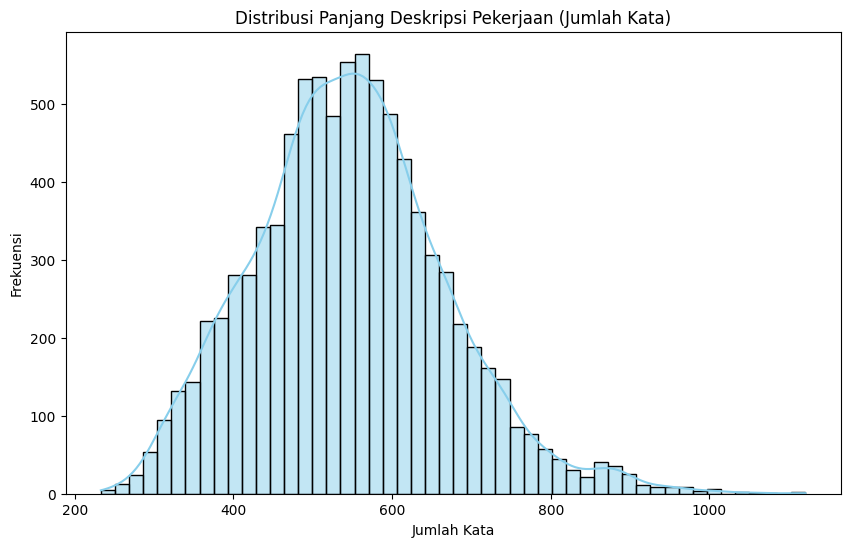

In [148]:
jobs['desc_length'] = jobs['description'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10,6))
sns.histplot(jobs['desc_length'], bins=50, kde=True, color='skyblue')
plt.title('Distribusi Panjang Deskripsi Pekerjaan (Jumlah Kata)')
plt.xlabel('Jumlah Kata')
plt.ylabel('Frekuensi')
plt.show()

## Data Preparation untuk Modelling

### Membuat fitur gabungan

Gabungkan job_title dan job_description sebagai fitur teks

In [149]:
jobs['job_title'] = jobs['job_title'].fillna('').str.lower().str.strip()
jobs['description'] = jobs['description'].fillna('').str.lower().str.strip()
jobs['features'] = jobs['job_title'] + ' ' + jobs['description']

## Pemodelan Sistem Rekomendasi Berbasis Konten (Content Based Filtering)

### Vektorisasi TF-IDF dan Hitung Cosine Similarity

In [154]:
custom_stopwords = list(text.ENGLISH_STOP_WORDS.union([
    'le', 'la', 'les', 'des', 'du', 'un', 'une', 'et', 'à', 'de', 'en', 'que', 'qui', 'dans'
]))
tfidf = TfidfVectorizer(stop_words=custom_stopwords)
tfidf_matrix = tfidf.fit_transform(jobs['features'])
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Model Development

## Rekomendasi Pekerjaan

### Fungsi Rekomendasi Pekerjaan

In [155]:
print(jobs['job_title'].unique())

['stagiaire (h/f) assistant marketing nutritionnel'
 'expert process traitement thermique h/f'
 "charge d'operation grands comptes h/f" ...
 'développeur/intégrateur logiciel algorithmes c2h/f'
 'attaché (e) commercial (e) itinérant (e) chr h/f'
 'stagiaire (h/f) projet entrepot (6mois)']


In [156]:
def recommend_jobs(title, cosine_sim=cosine_sim, top_n=5):
    title = title.lower().strip()
    jobs['job_title_clean'] = jobs['job_title'].str.lower().str.strip()
    indices = pd.Series(jobs.index, index=jobs['job_title_clean']).drop_duplicates()

    if title not in indices:
        print(f"Judul '{title}' tidak ditemukan.")
        close_matches = jobs['job_title_clean'].drop_duplicates().sample(3).tolist()
        print("Coba salah satu judul ini:", close_matches)
        return pd.DataFrame()

    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]  # ambil top N teratas (selain dirinya sendiri)
    job_indices = [i[0] for i in sim_scores]

    return jobs.iloc[job_indices][['job_title', 'description']]

### Contoh rekomendasi pekerjaan mirip "Expert process traitement thermique"

In [157]:
print("Rekomendasi pekerjaan mirip dengan 'Expert process traitement thermique h/f':")
print(recommend_jobs('Expert process traitement thermique h/f'))

Rekomendasi pekerjaan mirip dengan 'Expert process traitement thermique h/f':
                              job_title  \
1553       ingénieur(e) thermique (h/f)   
5539  ingénieur méthodes production h/f   
2860        ingénieur de production h/f   
28           responsable q.h.s.e. (h/f)   
3759    ingénieur industrialisation h/f   

                                            description  
1553  entreprise    société d'ingénierie /bureau d'é...  
5539  entreprise    rejoignez un acteur majeur indus...  
2860  entreprise    notre client est un industriel s...  
28    entreprise    notre groupe de dimension intern...  
3759  entreprise    notre client basé proche de vire...  


## Evaluasi Sistem Rekomendasi

### Menghitung Precision dan Recall

Fungsi untuk menghitung precision dan recall

In [161]:
def precision_recall_content_based(input_title, recommended_df, k=5):
    if recommended_df.empty:
        print("Tidak ada rekomendasi yang dihasilkan.")
        return 0.0, 0.0

    input_vec = tfidf.transform([input_title.lower().strip()])
    rec_titles = recommended_df['job_title'].str.lower().str.strip().tolist()
    rec_vecs = tfidf.transform(rec_titles)

    sim_scores = cosine_similarity(input_vec, rec_vecs)[0]

    precision = sim_scores[:k].mean()
    recall = sim_scores[:k].sum() / sim_scores.sum() if sim_scores.sum() > 0 else 0

    return precision * 100, recall * 100


In [165]:
input_job = "Expert process traitement thermique h/f"
recommended = recommend_jobs(input_job, cosine_sim=cosine_sim, top_n=5)

if not recommended.empty:
    precision, recall = precision_recall_content_based(input_job, recommended, k=5)
    print(f"Precision untuk '{input_job}': {precision:.2f}%")
    print(f"Recall untuk '{input_job}': {recall:.2f}%")
else:
    print("Rekomendasi tidak tersedia.")

Precision@5 untuk 'Expert process traitement thermique h/f': 11.95%
Recall@5 untuk 'Expert process traitement thermique h/f': 100.00%


# Kesimpulan

Dalam proyek sistem rekomendasi pekerjaan ini, kami berhasil membangun model rekomendasi berbasis content-based filtering menggunakan dataset pekerjaan dari Kaggle. Dengan memanfaatkan fitur teks gabungan dari judul pekerjaan dan deskripsi pekerjaan, serta metode TF-IDF dan cosine similarity, sistem dapat memberikan rekomendasi pekerjaan yang relevan dan mirip dengan input pekerjaan yang diberikan pengguna.

Hasil eksplorasi data menunjukkan variasi yang cukup besar pada jenis pekerjaan dan deskripsi yang cukup beragam, sehingga metode TF-IDF efektif dalam menangkap karakteristik teks untuk membandingkan kesamaan pekerjaan. Visualisasi WordCloud dan distribusi job title memberikan wawasan tentang kata-kata dominan dan jenis pekerjaan yang paling banyak muncul dalam dataset.

Evaluasi sederhana menggunakan metrik precision dan recall pada rekomendasi juga menunjukkan performa yang cukup baik dalam merekomendasikan pekerjaan serupa secara kontekstual berdasarkan fitur teks. Namun, sistem ini masih memiliki keterbatasan karena hanya mengandalkan kesamaan konten tanpa memperhitungkan preferensi atau riwayat pengguna secara eksplisit.

Untuk pengembangan selanjutnya, sistem rekomendasi ini dapat diperkaya dengan pendekatan hybrid yang menggabungkan collaborative filtering, atau menambahkan fitur-fitur personalisasi untuk meningkatkan relevansi rekomendasi bagi setiap pengguna. Selain itu, penambahan preprocessing teks yang lebih mendalam dan teknik embedding yang lebih canggih juga dapat meningkatkan kualitas rekomendasi pekerjaan.

Secara keseluruhan, sistem ini memberikan solusi awal yang efektif dalam membantu pencari kerja menemukan pekerjaan yang relevan dan sesuai dengan minat serta keahlian mereka berdasarkan kemiripan konten pekerjaan.